# GAN Generator Network

Default Loading

In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading pre-trained Surrogate

In [2]:
from models.neural_rendering import RenderDataset, Evaluator, SurrogateVAE, Inference

def full_path(relative_path):
    return os.path.join(base_path, relative_path)

if 'google.colab' in str(get_ipython()):
    base_path = '/content/drive/MyDrive/Master-Thesis'
else:
    base_path = ''

num_params = 77

rig_params_json_path = full_path('data/render_trainset/rendering_rig_params.json')
train_set_path = full_path('data/render_trainset')
idle_img_path = full_path('data/render_trainset/idle.png')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SurrogateVAE(num_params=num_params)
model.load_state_dict(torch.load('checkpoints/Neural_Rendering/model_weights_77.pth', map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

SurrogateVAE(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (film_layer): FiLMLayer(
    (scale_transform): Linear(in_features=77, out_features=256, bias=True)
    (shift_transform): Linear(in_features=77, out_features=256, bias=True)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262221, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=262144, bias=True)
    (3): ReLU()
  

### Test inference with Surrogate Variational Autoencoder:

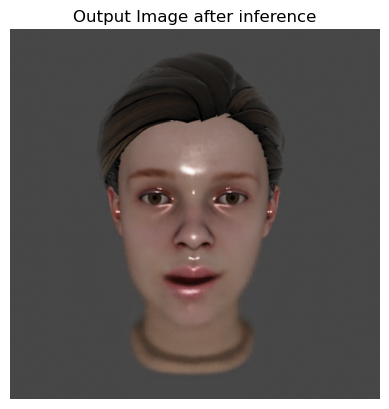

In [4]:
rig_param_values = [0, 0.2, -0.8, 0.0, 0.0, 0.0, 0.0, -2, 0.2, -0.3, 0.0, 0.0, 0.0, 0.0, -0.1, -0.01, -0.1, 0.0, 0.0, 0.0, 0.0, -0.1, 0.1, -4, 0.0, 0.0, 0.0, 0.0, 0.1, -0.03, -0.2, 0.0, 0.0, 0.0, 0.0, 0.02, 0.01, 0.16, 0.0, 0.0, 0.0, 0.0, -0.35, 0.14, -0.30, 0.0, 3.002625589942909e-06, -5.607937964668963e-06, 8.361090294783935e-06, -0.06107807159423828, 0.15036296844482422, -0.119140625, 0.0, 4.3709578676498495e-06, 7.03985597283463e-06, -8.000141860975418e-06, -0.22553014755249023, 0.1323099136352539, -0.433349609375, 0.0, -1.8065652511722874e-06, -5.944726581219584e-06, 0.0, -0.5, 0.5, 0.1, 0.0, 0.0, 0.0, 0.0, 0.01, -0.05, 0.16, 0.0, 0.0, 0.0, 0.0]
rig_params = torch.tensor([rig_param_values], dtype=torch.float32).to(device)

vae_evaluator = Inference(model, idle_img_path, device='cuda' if torch.cuda.is_available() else 'cpu')

vae_output = vae_evaluator.inference(rig_params)
vae_evaluator.inference_display_results(vae_output)

## Setup pre-trained DeepFace Emotion Classifier

Outputs the Emotion scores for the sample rendering we just created with the pre-trained VAE

In [5]:
from deepface import DeepFace
emotion_score = DeepFace.analyze(vae_output, actions = ['emotion'], enforce_detection = False)[0]['emotion']
print(emotion_score)

{'angry': 81.68504456459945, 'disgust': 0.00185413715096232, 'fear': 0.05763246340029378, 'happy': 2.015825120708332, 'sad': 3.0020030362006382, 'surprise': 2.767953877990976, 'neutral': 10.469681266584246}


## GAN Setup and Training

In [31]:
from models.generator import Generator, GANTrainer
import torch.nn.functional as F

In [32]:
if 'google.colab' in str(get_ipython()):
    base_path = '/content/drive/MyDrive/Master-Thesis'
else:
    base_path = ''

generator = Generator(num_emotions=7, hidden_dim=128, output_dim=77, num_params=77, base_path=base_path).to(device)

In [33]:
trainer = GANTrainer(generator)

In [34]:
# Create a DataLoader with random one-hot encoded emotion vectors
num_samples = 100
emotions = torch.randint(0, 7, (num_samples,))  # Random integers for 7 emotion states
one_hot_emotions = F.one_hot(emotions, num_classes=7).float().to(device)
rig_params = torch.randn(num_samples, generator.num_params).to(device)  # Random rig parameters as dummy input

In [35]:
# DataLoader setup
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(one_hot_emotions, rig_params)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [36]:
trainer.train(dataloader, epochs=20)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn